# WEEK 4: ML & DL for NLP - SVM & Naive Bayes

Nguyen Luu Phuong Ngoc Lam - 240108

## 1. Preparation

In [16]:
!pip install underthesea 
from underthesea import word_tokenize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 59.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 27.1 MB/s eta 0:00:00


In [110]:
# Library Classification

# Data Processing Libraries
import pandas as pd
import numpy as np

# Text Processing Libraries
import string
from wordcloud import WordCloud
from underthesea import word_tokenize
from gensim.models import Word2Vec

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix


## 2. Load dataset and EDA

In [19]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)

df = pd.read_csv(file_path, header = None, names = ['label','content'])
df.head(10)

,label,content
0,0,máy dùng hay bị đơ máy
1,0,chỉ có dây cáp nguồn không có adapter sao sử d...
2,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
3,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
4,2,Tuyệt vời. Hàng FPT cửa hàng
5,1,Chưa đo đúng bước chân rõ Nhiều khi gián đoạn ...
6,0,phủ sóng thấp quá đi khoảng 3 4m là mất sóng
7,1,Kết nối tốt Mối nối không khít gây đau tai 1 K...
8,0,2 Loa nhỏ nghe bị rè Âm thanh chưa tốt hơi thấ...
9,0,Đặt i12 shop giao i11 thất vọng


In [26]:
label_counts = df['label'].value_counts()
print("Label distribution:\n", label_counts)


Label distribution:
 label
0    1105
2    1048
1     887
Name: count, dtype: int64
Number of content rows:  2998


In [36]:
duplicates = df[df.duplicated(subset=['content'], keep=False)].sort_values(by='content')
print(duplicates[['content', 'label']])

                                                content  label
2511  Bình thường Cách đây 2 hôm mình có đặt mua thì...      1
820   Bình thường Cách đây 2 hôm mình có đặt mua thì...      1
1086  Bình thường Giao hàng nhanh sản phẩm tốt tùy n...      1
727   Bình thường Giao hàng nhanh sản phẩm tốt tùy n...      1
1749  Bình thường Sản phẩm ok Nhưng hàng giao quá ch...      1
...                                                 ...    ...
1608  ĐẶT MÀU CAM GIAO MÀU ĐEN Nhưng chất lượng máy ...      1
2695  đo sức khỏe không đúng nếu mua vì giá và không...      1
2002  đo sức khỏe không đúng nếu mua vì giá và không...      1
2421  Ổn nhưng chưa hài lòng lắm Mình mua sản phẩm c...      1
2490  Ổn nhưng chưa hài lòng lắm Mình mua sản phẩm c...      1

[84 rows x 2 columns]


In [37]:
df = df.drop_duplicates(subset=['content'])

In [38]:
print("Number of label rows: ", df['label'].count())
print("Number of content rows: ", df['content'].nunique())

Number of label rows:  2998
Number of content rows:  2998


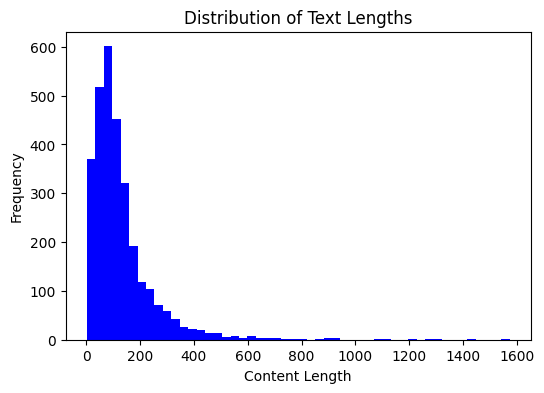

In [43]:
df['content_length'] = df['content'].apply(len)
plt.figure(figsize=(6,4))
n, bins, patches = plt.hist(df['content_length'], bins=50, color='blue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Content Length')
plt.ylabel('Frequency')
plt.show()

In [44]:
max_freq_length = bins[n.argmax()]
print("Content length with the highest frequency:", max_freq_length)

Content length with the highest frequency: 64.84


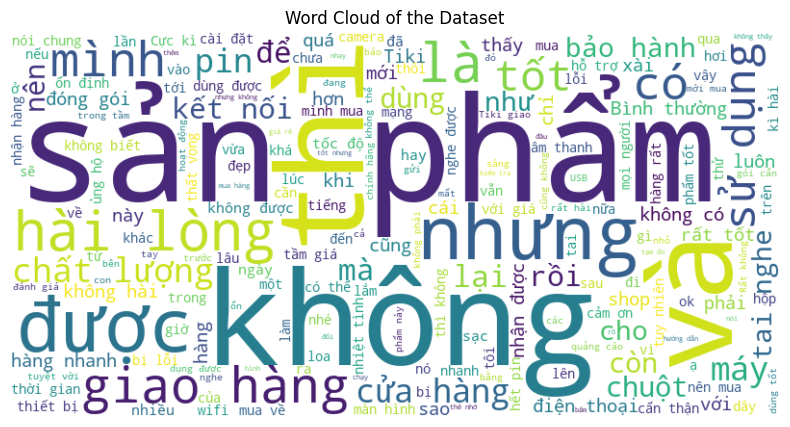

In [45]:
all_text = ' '.join(df['content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of the Dataset')
plt.show()

In [49]:
def extract_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
        "]+", flags=re.UNICODE)
    
    return emoji_pattern.findall(text)

df['extracted_emojis'] = df['content'].apply(extract_emojis)
all_emojis = [emoji for sublist in df['extracted_emojis'] for emoji in sublist]
emoji_df = pd.DataFrame(all_emojis, columns=['emoji'])
df.drop(columns=['extracted_emojis'], inplace=True)

print("List of emoji:")
print(emoji_df['emoji'].unique())  

List of emoji:
['😆😆😆' '😢😢' '☺☺' '❤' '😌' '😁' '，']


## 3. Preprocessing Data

In [84]:
import re
import string
from underthesea import word_tokenize

# Danh sách từ phủ định, tích cực, tiêu cực, trung tính và stopwords
not_list = ['chẳng', 'không', 'chưa', 'không phải', 'đừng', 'chối']
pos_list = ['đẹp', 'tốt', 'thích', 'tuyệt', 'hay', 'ok', 'xuất sắc', 'cảm ơn']
nega_list = ['xấu', 'tệ', 'không thích', 'chán', 'bực', 'dở', 'tệ hại']
neutral_list = ['tạm được', 'bình thường', 'cũng được', 'thường thôi']  # Danh sách từ trung tính
stop_ws = (u'rằng', u'thì', u'là', u'mà')

def normalize_text(text):
    """
    Normalize the input text by removing unwanted characters, handling negations,
    and classifying sentiment into positive, negative, neutral, or not.
    """
    
    # Remove các ký tự kéo dài: vd: đẹppppppp
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)
    
    # Chuyển thành chữ thường
    text = text.lower()

    # Chuẩn hóa tiếng Việt, xử lý emoji, chuẩn hóa tiếng Anh, thuật ngữ
    replace_list = {
        '😆': 'pos', '😢': 'nega', '☺': 'pos', '❤': 'pos', '😌': 'pos', '😁': 'pos', '，': ' ',
    }
    
    for k, v in replace_list.items():
        text = text.replace(k, v)

    # Chuyển punctuation thành space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)

    # Tokenize
    tokens = word_tokenize(text)

    # Loại bỏ stopwords
    texts = [word for word in tokens if word not in stop_ws]

    # List để lưu các nhãn cảm xúc
    sentiment_label = None

    # Xử lý phủ định và sentiment words
    len_text = len(texts)
    for i in range(len_text):
        cp_text = texts[i]
        if cp_text in not_list:  # Xử lý các từ phủ định
            numb_word = 2 if len_text - i - 1 >= 4 else len_text - i - 1
            for j in range(numb_word):
                if texts[i + j + 1] in pos_list:
                    sentiment_label = 'notpos'
                    texts[i + j + 1] = ''
                    break  # Dừng xử lý khi tìm thấy nhãn cảm xúc đầu tiên

                if texts[i + j + 1] in nega_list:
                    sentiment_label = 'notnega'
                    texts[i + j + 1] = ''
                    break  # Dừng xử lý khi tìm thấy nhãn cảm xúc đầu tiên
        else:  # Xử lý từ tích cực, tiêu cực và trung tính
            if cp_text in pos_list:
                sentiment_label = 'positive'
                break  # Dừng xử lý khi tìm thấy nhãn cảm xúc đầu tiên
            elif cp_text in nega_list:
                sentiment_label = 'negative'
                break  # Dừng xử lý khi tìm thấy nhãn cảm xúc đầu tiên
            elif cp_text in neutral_list:
                sentiment_label = 'neutral'
                break  # Dừng xử lý khi tìm thấy nhãn cảm xúc trung tính

    # Nếu không tìm thấy từ tích cực, tiêu cực hay phủ định, kiểm tra từ trung tính
    if not sentiment_label:
        for word in texts:
            if word in neutral_list:
                sentiment_label = 'neutral'
                break

    # Loại bỏ các chuỗi rỗng do xử lý trước đó
    texts = [word for word in texts if word]

    # Kết hợp lại thành câu đã chuẩn hóa
    text = ' '.join(texts).strip()

    # Thêm nhãn cảm xúc vào cuối câu nếu có
    if sentiment_label:
        text += ' ' + sentiment_label

    return text

text_samples = ['Sản phẩm này bình thường', 'Tôi rất thích món này', 'Đồ ăn ở đây tệ quá']
cleaned_texts = [normalize_text(text) for text in text_samples]

print(cleaned_texts)


['sản phẩm này bình thường neutral', 'tôi rất thích món này positive', 'đồ ăn ở đây tệ quá negative']


In [79]:
## Apply all dataframe
df['clean_content'] = df['content'].apply(normalize_text)
df.tail()

,label,content,content_length,clean_content
3033,1,Nhanh hết pin Không biết phải lỗi hay không Mà...,261,nhanh hết pin không biết phải lỗi hay không cá...
3035,0,không có bộ thu đi kèm Vừa nhận hàng xong tức ...,120,không có bộ thu đi kèm vừa nhận hàng xong tức ...
3036,0,Cũng bình thường Không mạnh như kỹ vọng Chắc t...,99,cũng bình thường không mạnh như kỹ vọng chắc t...
3037,2,tốt tốt đang tiền khi bỏ ra để mua giao hàng n...,68,tốt tốt đang tiền khi bỏ ra để mua giao hàng n...
3039,2,quá tuyệt vời với giá và miễn phí giao hàng ch...,142,quá tuyệt vời với giá và miễn phí giao hàng ch...


## 4. Embedding data

In [90]:
tokenized_data = [word_tokenize(text) for text in df['clean_content']] 

w2v_model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, sg=1)

print(w2v_model.wv['sản phẩm'])

[-0.06241461  0.21447788  0.12282632 -0.02958332 -0.11584324 -0.30033424
  0.05811998  0.44983032 -0.12959863 -0.30119902  0.07186552 -0.6141765
  0.00242786  0.07955249 -0.02008604 -0.35140985  0.13856623 -0.25262302
 -0.361582   -0.71597624  0.19180252 -0.15207265  0.14691181 -0.06854481
  0.08563843  0.128138   -0.23448476 -0.12380557 -0.08474087  0.10502408
  0.19546545 -0.04077536  0.10759591 -0.46443614 -0.33679006  0.20413448
  0.11061052 -0.15521474  0.02336323 -0.43291524  0.00928776 -0.00929611
  0.10369657  0.12365431  0.31580532 -0.19816041 -0.10172416  0.17837101
  0.47601467  0.19344391 -0.21369524 -0.12847292  0.06786384 -0.15102577
 -0.06014971  0.11086462 -0.08990327 -0.02497384 -0.10051465  0.00851149
 -0.03047295 -0.08900489  0.32083505  0.15855472 -0.26941323  0.34397644
  0.00723692  0.61289877 -0.41113436  0.4538619   0.01029953  0.4409626
  0.34106588  0.12266333  0.23606361  0.18531103  0.04415051 -0.04911996
 -0.40939736  0.21770126 -0.3367475  -0.05915134 -0.3

In [121]:
def get_mean_vector(model, tokens_list, vector_size):
    return model.wv.get_mean_vector(tokens_list, ignore_missing=True)

X_w2v = np.vstack([get_mean_vector(w2v_model, word_tokenize(text), 100) for text in df['clean_content']])
y = df['label'].values

## 5. Training Data

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (2398, 100)
X_test shape: (600, 100)


### 5.1. SVM

In [103]:
# Parameters for SVM model
svm_params = {
    'svm__kernel': ['linear', 'rbf', 'poly'],  
    'svm__C': [0.1, 1, 10],  
    'svm__degree': [2, 3, 4],  
    'svm__gamma': ['scale', 'auto', 0.1, 1, 10]  
}

# Create Pipeline with StandardScaler and SVC
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Initialize GridSearchCV
svm_grid = GridSearchCV(svm_pipeline, param_grid=svm_params, cv=3, scoring='accuracy', n_jobs=-1)

# Train the model
svm_grid.fit(X_train, y_train)

# Print best parameters
print("Best parameters for SVM:", svm_grid.best_params_)

# Predict on test set
y_pred_svm = svm_grid.predict(X_test)

# Print classification report
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Print accuracy
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


Best parameters for SVM: {'svm__C': 10, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       234
           1       0.57      0.55      0.56       157
           2       0.83      0.82      0.83       209

    accuracy                           0.75       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.74      0.75      0.75       600

SVM Accuracy: 0.7466666666666667


### 5.2. Naive Bayes

In [125]:
# Parameter grid for each Naive Bayes model
params = {
    'MultinomialNB': {
        'mnb__alpha': [0.1, 0.5, 1, 2, 5]
    },
    'BernoulliNB': {
        'bnb__alpha': [0.1, 0.5, 1, 2, 5],
        'bnb__binarize': [0.0, 0.1, 0.5, 1.0]
    },
    'GaussianNB': {}
}

# Pipelines for each model
pipelines = {
    'MultinomialNB': Pipeline([
        ('scaler', MinMaxScaler()),
        ('mnb', MultinomialNB())
    ]),
    
    'BernoulliNB': Pipeline([
        ('scaler', StandardScaler()),
        ('bnb', BernoulliNB())
    ]),
    
    'GaussianNB': Pipeline([
        ('scaler', StandardScaler()),
        ('gnb', GaussianNB())
    ])
}

# Function to train and evaluate the model
def train_and_evaluate(pipeline, params, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)
    
    grid.fit(X_train, y_train)
    
    print(f"Best parameters for {pipeline.steps[-1][0]}:", grid.best_params_)
    
    y_pred = grid.predict(X_test)
    
    print(f"\nClassification Report for {pipeline.steps[-1][0]}:")
    print(classification_report(y_test, y_pred))
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("-" * 50)

# Train and evaluate all 3 models
for model_name, pipeline in pipelines.items():
    print(f"Training and evaluating {model_name}...\n")
    train_and_evaluate(pipeline, params[model_name], X_train, y_train, X_test, y_test)


Training and evaluating MultinomialNB...

Best parameters for mnb: {'mnb__alpha': 5}

Classification Report for mnb:
              precision    recall  f1-score   support

           0       0.65      0.86      0.74       234
           1       0.45      0.21      0.29       157
           2       0.72      0.75      0.74       209

    accuracy                           0.65       600
   macro avg       0.61      0.61      0.59       600
weighted avg       0.62      0.65      0.62       600

mnb Accuracy: 0.6516666666666666
--------------------------------------------------
Training and evaluating BernoulliNB...

Best parameters for bnb: {'bnb__alpha': 0.1, 'bnb__binarize': 0.5}

Classification Report for bnb:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       234
           1       0.36      0.32      0.34       157
           2       0.73      0.73      0.73       209

    accuracy                           0.63       600
   macr

### 5.3. Confusion Matrix

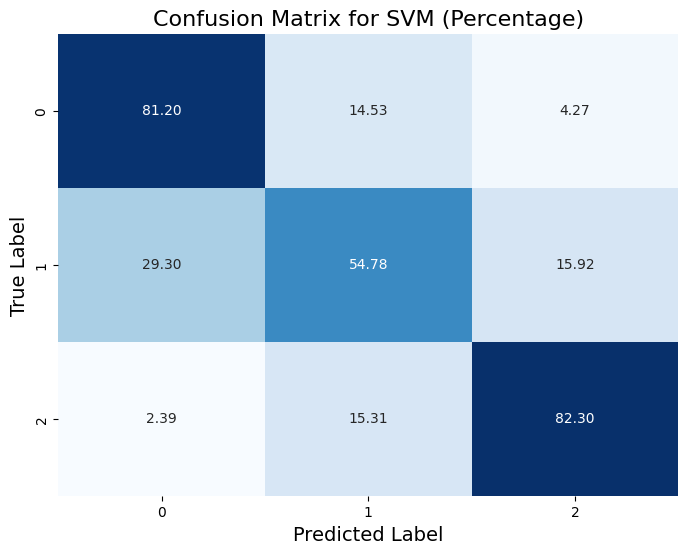

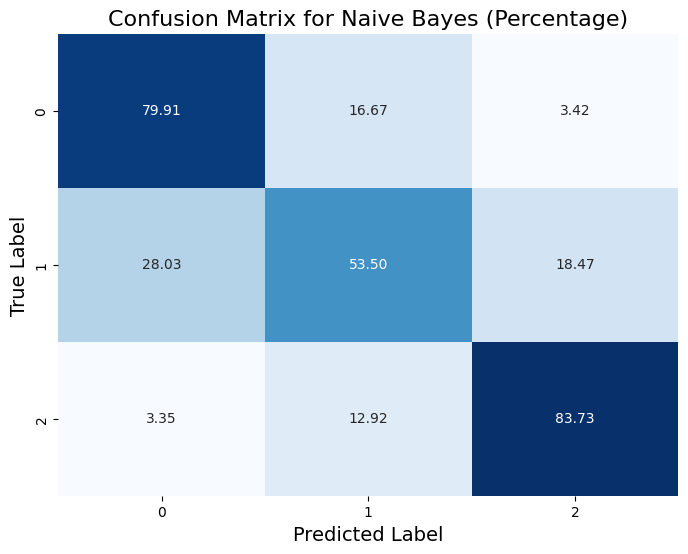

In [129]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots the confusion matrix as a percentage for a given model.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    
    plt.title(f'Confusion Matrix for {model_name} (Percentage)', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    
    plt.show()

plot_confusion_matrix(y_test, y_pred_svm, model_name='SVM')
plot_confusion_matrix(y_test, y_pred, model_name='Naive Bayes')
